## Notebook to develop the PEA/OSS strategy

In [1]:
from ib_async import *
import pandas as pd
import numpy as np
from datetime import datetime, time, timedelta
import yfinance as yf
from broker.connection import connect_to_IB
from broker.riskmanager import RiskManager
from data_and_research import ac
import broker.utilityfunctions as uf

Connected to ArcticDB at ../db


In [2]:
ib = connect_to_IB(clientid=5)


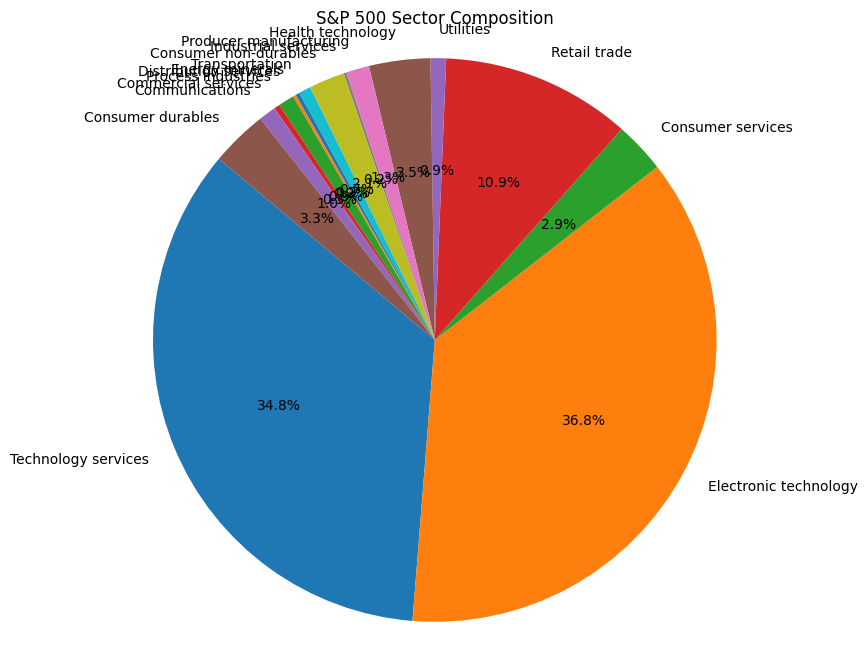

defaultdict(float,
            {'Technology services': 8525285000000.0,
             'Electronic technology': 9000277000000.0,
             'Consumer services': 718148000000.0,
             'Retail trade': 2664951000000.0,
             'Utilities': 218400000000.0,
             'Health technology': 858561000000.0,
             'Producer manufacturing': 326400000000.0,
             'Industrial services': 37681000000.0,
             'Consumer non-durables': 503234000000.0,
             'Transportation': 167598000000.0,
             'Energy minerals': 57360000000.0,
             'Distribution services': 40188000000.0,
             'Process industries': 223557000000.0,
             'Commercial services': 81132000000.0,
             'Communications': 243018000000.0,
             'Consumer durables': 798916000000.0})

In [2]:
uf.get_index_sector_composition(source='universe',index='qqq')

In [5]:
self = RiskManager(ib)

In [6]:
portfolio =self.get_portfolio_data()

In [7]:
portfolio.head()

,contract,position,marketPrice,marketValue,averageCost,unrealizedPNL,realizedPNL,account,symbol,asset_class
0,"Stock(conId=14016560, symbol='6368', right='0'...",200.0,7866.000000,1573200.00,7033.215000,166557.00,0.0,U7706434,6368,<class 'ib_async.contract.Stock'>
1,"Stock(conId=13905785, symbol='7012', right='0'...",100.0,6544.000000,654400.00,4618.480000,192552.00,0.0,U7706434,7012,<class 'ib_async.contract.Stock'>
2,"Stock(conId=70332154, symbol='960', right='0',...",500.0,13.364300,6682.15,10.472886,1445.71,0.0,U7706434,960,<class 'ib_async.contract.Stock'>
3,"Option(conId=726994679, symbol='AMD', lastTrad...",-1.0,0.124697,-12.47,149.939700,137.47,0.0,U7706434,AMD,<class 'ib_async.contract.Option'>
4,"Option(conId=683238380, symbol='AMD', lastTrad...",-1.0,21.615162,-2161.52,2204.132600,42.62,0.0,U7706434,AMD,<class 'ib_async.contract.Option'>


In [25]:
lib = ac.get_library('univ')
universe = lib.read('us_equities').data
universe

,Symbol,Name,Price,Change %,Volume,Rel Volume,Market Cap,P/E,EPS (dil TTM),EPS Growth (TTM YoY),Div Yield % TTM,Sector,Analyst Rating
0,A,"Agilent Technologies, Inc.",144.97,+0.29%,1001000.0,0.57,4.165400e+10,30.04,4.83 USD,+26.54%,0.64%,Health technology,Buy
1,AA,Alcoa Corporation,39.12,+2.49%,4145000.0,0.71,1.010600e+10,—,−3.08 USD,+62.20%,1.02%,Non-energy minerals,Buy
2,AACT,Ares Acquisition Corporation II,10.84,0.00%,24842.0,0.24,6.771880e+08,25.72,0.42 USD,—,0.00%,Finance,—
3,AADI,"Aadi Bioscience, Inc.",1.94,+1.04%,55050.0,0.38,4.775300e+07,—,−2.43 USD,+0.34%,0.00%,Health technology,Neutral
4,AAL,"American Airlines Group, Inc.",11.51,+6.38%,53739000.0,1.12,7.559000e+09,—,−0.28 USD,−107.72%,0.00%,Transportation,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,ZVRA,"Zevra Therapeutics, Inc.",7.20,+0.28%,718964.0,0.40,3.788480e+08,—,−1.68 USD,−77.61%,0.00%,Health technology,Strong buy
4630,ZVSA,"ZyVersa Therapeutics, Inc.",2.24,−0.88%,13069.0,0.38,2.406000e+06,—,−73.92 USD,+96.78%,0.00%,Health technology,—
4631,ZWS,Zurn Elkay Water Solutions Corporation,36.38,+0.69%,1431000.0,0.39,6.218000e+09,47.11,0.77 USD,+184.00%,0.88%,Producer manufacturing,Buy
4632,ZYME,Zymeworks Inc.,12.57,+3.12%,536324.0,0.80,9.002390e+08,—,−1.52 USD,−154.29%,0.00%,Health technology,Buy


In [22]:
for contract in portfolio['contract']:
    if isinstance(contract, Option):
        symbol = contract.symbol
        if symbol in universe['Symbol'].values:
            sector = universe.loc[universe['Symbol'] == symbol, 'Sector'].values[0]
            print(symbol, sector)

AMD Electronic technology
AMD Electronic technology
AMD Electronic technology
APLD Technology services
APOG Producer manufacturing
CALM Process industries
DAL Transportation
DPZ Consumer services
HELE Consumer durables
JPM Finance
MMYT Technology services
PLTR Technology services
PTON Consumer services


In [25]:
# Method 1: Using yfinance
info_dict = {}
for _, row in portfolio.iterrows():
    if isinstance(contract, Option):
        if np.sign(row['position']) == -1 and row['contract'].right == 'P':
            symbol = row['contract'].symbol
            info = yf.Ticker(symbol).info
            info_dict[symbol] = info

for key, value in info_dict.items():
    try:
        print(key, value['sector'])
    except:
        next

In [28]:
info_dict = {}
total_capital_at_risk = 0
cap_at_risk = np.array([])  
dte_array = np.array([])
sectors = np.array([])

for _, row in portfolio.iterrows():
    if isinstance(row['contract'], Option):
        
        if np.sign(row['position']) == -1 and row['contract'].right == 'P':
            symbol = row['contract'].symbol
            info = yf.Ticker(symbol).info
            info_dict[symbol] = info
            try:
                sector = info['sector']
                sectors = np.append(sectors, sector)
            except:
                next
            
            cap_at_risk = np.append(cap_at_risk, abs(row['position']) * float(row['contract'].strike) * int(row['contract'].multiplier))
            last_trade_date = datetime.strptime(row['contract'].lastTradeDateOrContractMonth, '%Y%m%d')
            days_to_expiry = (last_trade_date - datetime.now()).days
            dte_array = np.append(dte_array, days_to_expiry)
            total_capital_at_risk += abs(row['position']) * float(row['contract'].strike) * int(row['contract'].multiplier)

average_dte = ((dte_array * cap_at_risk) / cap_at_risk.sum()).sum()
total_capital_at_risk


468251.0

In [31]:
sectors

array(['Technology', 'Technology', 'Technology', 'Technology',
       'Industrials', 'Consumer Defensive', 'Industrials',
       'Consumer Cyclical', 'Consumer Defensive', 'Real Estate',
       'Financial Services', 'Technology', 'Consumer Cyclical'],
      dtype='<U32')

In [32]:
cap_at_risk

array([13500., 18500., 20000.,   550.,  8000.,  7000.,  9000., 38500.,
       10400., 12000.,  5000., 13000., 21500., 21100.,  4200., 21500.,
       10000.,  8500., 46500., 42334., 21500., 22167., 47500., 46000.])

In [33]:
info_dict = {}
total_capital_at_risk = 0
cap_at_risk = np.array([])  
dte_array = np.array([])
sectors = np.array([])

for _, row in portfolio.iterrows():
    if isinstance(row['contract'], Option):
        
        if np.sign(row['position']) == -1 and row['contract'].right == 'P':
            symbol = row['contract'].symbol
            info = yf.Ticker(symbol).info
            info_dict[symbol] = info
            try:
                sector = info['sector']
                sectors = np.append(sectors, sector)
                
                # Append to cap_at_risk only if sector is found
                cap_at_risk = np.append(cap_at_risk, abs(row['position']) * float(row['contract'].strike) * int(row['contract'].multiplier))
                last_trade_date = datetime.strptime(row['contract'].lastTradeDateOrContractMonth, '%Y%m%d')
                days_to_expiry = (last_trade_date - datetime.now()).days
                dte_array = np.append(dte_array, days_to_expiry)
                total_capital_at_risk += abs(row['position']) * float(row['contract'].strike) * int(row['contract'].multiplier)
            except KeyError:
                # Handle the case where 'sector' is not found
                continue

average_dte = ((dte_array * cap_at_risk) / cap_at_risk.sum()).sum()
total_capital_at_risk

180050.0

In [44]:
total_capital_at_risk * 0.01

1800.5

In [29]:
from collections import defaultdict
import matplotlib.pyplot as plt



In [39]:
# Dictionary to hold capital at risk by sector
capital_by_sector = defaultdict(float)

# Aggregate capital at risk by sector
for cap, sector in zip(cap_at_risk, sectors):
    capital_by_sector[sector] += cap

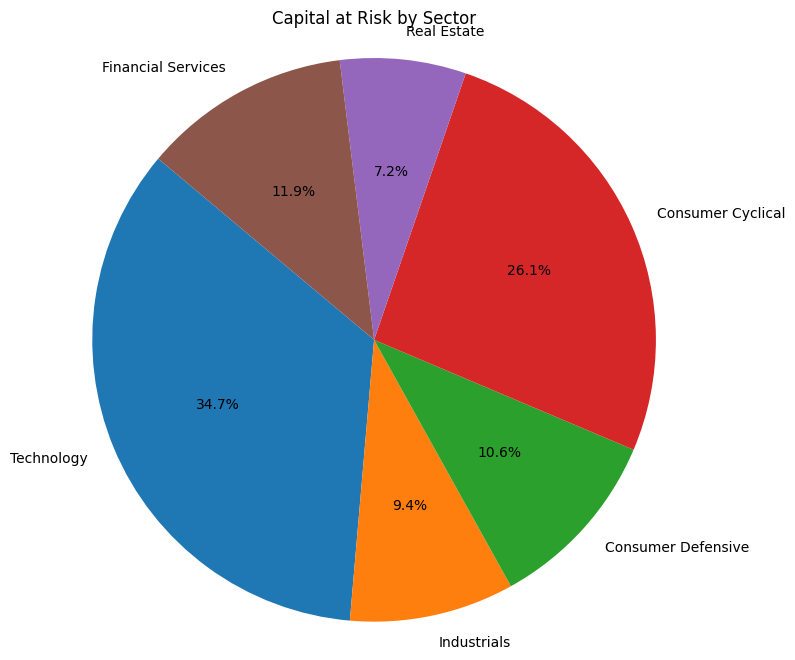

In [42]:

# Prepare data for the pie chart
labels = list(capital_by_sector.keys())
sizes = list(capital_by_sector.values())

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Capital at Risk by Sector')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [36]:
sectors

array(['Technology', 'Technology', 'Technology', 'Technology',
       'Industrials', 'Consumer Defensive', 'Industrials',
       'Consumer Cyclical', 'Consumer Defensive', 'Real Estate',
       'Financial Services', 'Technology', 'Consumer Cyclical'],
      dtype='<U32')

In [27]:
(dte * cap_at_risk) / cap_at_risk.sum()

array([0.34596829, 1.30378793, 2.90442519, 0.03053918, 0.08542427,
       0.49332516, 0.49973198, 2.13774236, 0.11105155, 0.84570028,
       0.05339017, 0.13881444, 0.22957773, 0.54073563, 0.04484774,
       0.55098654, 0.10678034, 0.09076329, 0.49652857, 0.45204388,
       0.22957773, 0.23669998, 6.89800983, 7.76079496])

In [8]:
universe.Symbol

0          A
1         AA
2       AACT
3       AADI
4        AAL
        ... 
2595     MCB
2596    MCBS
2597     MCD
2598    MCFT
2599    MCHP
Name: Symbol, Length: 2600, dtype: object

In [26]:
spx = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
spx.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [48]:
spx_symbols = spx['Symbol'].tolist()

# Create a dictionary to store sector and market cap information
spx_sector_market_cap = {}


# Iterate over SPX symbols
number_of_stocks = 0
for symbol in spx_symbols:
    if symbol in universe['Symbol'].values:
        stock_data = universe[universe['Symbol'] == symbol].iloc[0]
        sector = stock_data['Sector']
        market_cap = stock_data['Market Cap']
        
        if sector not in spx_sector_market_cap:
            spx_sector_market_cap[sector] = 0
        spx_sector_market_cap[sector] += market_cap
        number_of_stocks += 1
    else:
        print(symbol,"not in universe")
# Calculate total market cap
total_market_cap = sum(spx_sector_market_cap.values())

# Calculate percentage for each sector
spx_sector_composition = {sector: (market_cap / total_market_cap) * 100 
                          for sector, market_cap in spx_sector_market_cap.items()}

# Sort the dictionary by percentage in descending order
spx_sector_composition = dict(sorted(spx_sector_composition.items(), key=lambda x: x[1], reverse=True))

# Print the results
for sector, percentage in spx_sector_composition.items():
    print(f"{sector}: {percentage:.2f}%")
number_of_stocks


ARE not in universe
GOOGL not in universe
AMT not in universe
AVB not in universe
BRK.B not in universe
BF.B not in universe
BXP not in universe
CPT not in universe
CCI not in universe
DLR not in universe
EQIX not in universe
EQR not in universe
ESS not in universe
EXR not in universe
FRT not in universe
FOXA not in universe
DOC not in universe
HST not in universe
INVH not in universe
IRM not in universe
KIM not in universe
MAA not in universe
NWSA not in universe
PLD not in universe
PSA not in universe
O not in universe
REG not in universe
SBAC not in universe
SPG not in universe
UDR not in universe
VTR not in universe
VICI not in universe
WELL not in universe
WY not in universe
Producer manufacturing: nan%
Health technology: nan%
Technology services: nan%
Electronic technology: nan%
Utilities: nan%
Finance: nan%
Process industries: nan%
Consumer services: nan%
Consumer non-durables: nan%
Retail trade: nan%
Energy minerals: nan%
Communications: nan%
Industrial services: nan%
Transport

469

In [45]:
universe

,Symbol,Name,Price,Change %,Volume,Rel Volume,Market Cap,P/E,EPS (dil TTM),EPS Growth (TTM YoY),Div Yield % TTM,Sector,Analyst Rating
0,A,"Agilent Technologies, Inc.",144.97,+0.29%,1001000.0,0.57,4.165400e+10,30.04,4.83 USD,+26.54%,0.64%,Health technology,Buy
1,AA,Alcoa Corporation,39.12,+2.49%,4145000.0,0.71,1.010600e+10,—,−3.08 USD,+62.20%,1.02%,Non-energy minerals,Buy
2,AACT,Ares Acquisition Corporation II,10.84,0.00%,24842.0,0.24,6.771880e+08,25.72,0.42 USD,—,0.00%,Finance,—
3,AADI,"Aadi Bioscience, Inc.",1.94,+1.04%,55050.0,0.38,4.775300e+07,—,−2.43 USD,+0.34%,0.00%,Health technology,Neutral
4,AAL,"American Airlines Group, Inc.",11.51,+6.38%,53739000.0,1.12,7.559000e+09,—,−0.28 USD,−107.72%,0.00%,Transportation,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,ZVRA,"Zevra Therapeutics, Inc.",7.20,+0.28%,718964.0,0.40,3.788480e+08,—,−1.68 USD,−77.61%,0.00%,Health technology,Strong buy
4630,ZVSA,"ZyVersa Therapeutics, Inc.",2.24,−0.88%,13069.0,0.38,2.406000e+06,—,−73.92 USD,+96.78%,0.00%,Health technology,—
4631,ZWS,Zurn Elkay Water Solutions Corporation,36.38,+0.69%,1431000.0,0.39,6.218000e+09,47.11,0.77 USD,+184.00%,0.88%,Producer manufacturing,Buy
4632,ZYME,Zymeworks Inc.,12.57,+3.12%,536324.0,0.80,9.002390e+08,—,−1.52 USD,−154.29%,0.00%,Health technology,Buy


nan

In [28]:
yf.Ticker('AAPL').info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

In [70]:
# Method 2: Using the universe
import math
info_dict = {}

sectors = np.array([])
market_caps = np.array([])

for sym in spx_symbols:
    try:
        sector = universe.loc[universe['Symbol'] == sym, 'Sector'].values[0]
        market_cap = universe.loc[universe['Symbol'] == sym, 'Market Cap'].values[0]
        if math.isnan(market_cap):
            next 
        else:
            market_caps = np.append(market_caps, market_cap)
        sectors = np.append(sectors, sector)
    except:
        next

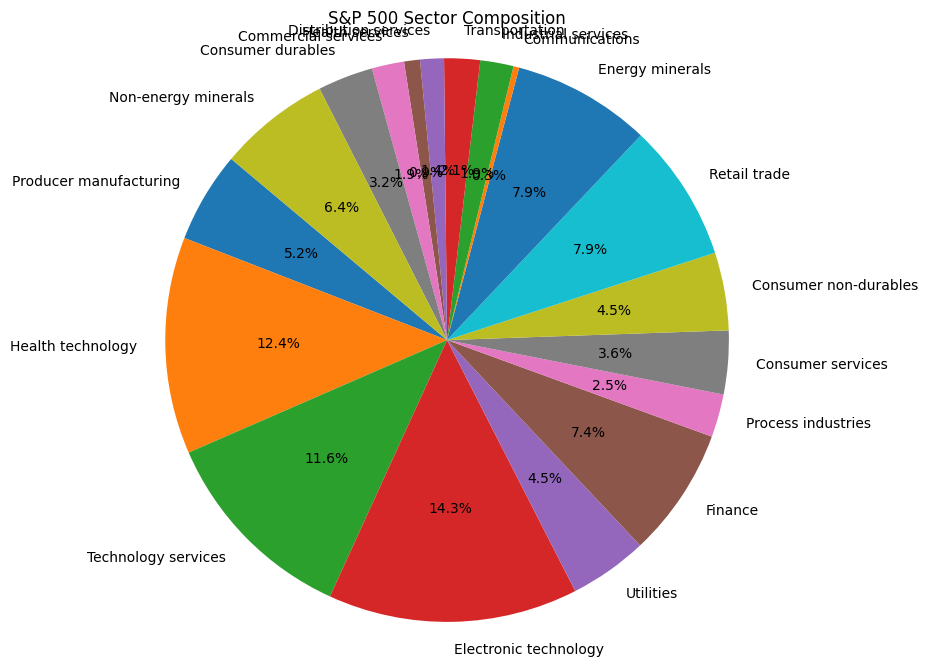

In [71]:
# Dictionary to hold capital at risk by sector
capital_by_sector = defaultdict(float)

# Aggregate capital at risk by sector
for cap, sector in zip(market_caps, sectors):
    capital_by_sector[sector] += cap

# Prepare data for the pie chart
labels = list(capital_by_sector.keys())
sizes = list(capital_by_sector.values())

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('S&P 500 Sector Composition')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [69]:
capital_by_sector

defaultdict(float,
            {'Producer manufacturing': 1862117000000.0,
             'Health technology': 4505664000000.0,
             'Technology services': nan,
             'Electronic technology': 10705784000000.0,
             'Utilities': 1277185000000.0,
             'Finance': 4540250000000.0,
             'Process industries': 857772000000.0,
             'Consumer services': 1577406000000.0,
             'Consumer non-durables': 2147438000000.0,
             'Retail trade': 4321243000000.0,
             'Energy minerals': 1444380000000.0,
             'Communications': 586095000000.0,
             'Industrial services': 489869000000.0,
             'Transportation': 758060000000.0,
             'Distribution services': 302970000000.0,
             'Health services': 1058271000000.0,
             'Commercial services': 1458715000000.0,
             'Consumer durables': 1111714000000.0,
             'Non-energy minerals': 253479000000.0})

In [30]:
info_dict = {}

sectors = np.array([])
market_caps = np.array([])

for sym in spx_symbols:
    info = yf.Ticker(sym).info
    info_dict[sym] = info
    try:
        sector = info['sector']
        sectors = np.append(sectors, sector)
        market_cap = info['marketCap']
        market_caps = np.append(market_caps, market_cap)
    except:
        next

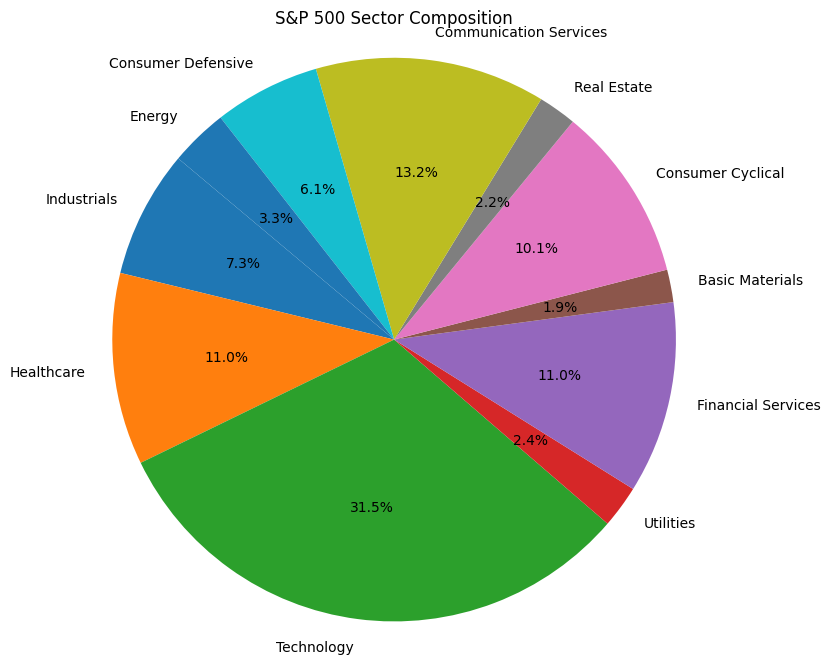

In [32]:
# Dictionary to hold capital at risk by sector
capital_by_sector = defaultdict(float)

# Aggregate capital at risk by sector
for cap, sector in zip(market_caps, sectors):
    capital_by_sector[sector] += cap

# Prepare data for the pie chart
labels = list(capital_by_sector.keys())
sizes = list(capital_by_sector.values())

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('S&P 500 Sector Composition')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [42]:
capital_by_sector

defaultdict(float,
            {'Industrials': 3882055473664.0,
             'Healthcare': 5848410488832.0,
             'Technology': 16717895661568.0,
             'Utilities': 1293356611584.0,
             'Financial Services': 5852289300480.0,
             'Basic Materials': 992267961856.0,
             'Consumer Cyclical': 5352752757248.0,
             'Real Estate': 1165294669824.0,
             'Communication Services': 7021231818240.0,
             'Consumer Defensive': 3231785527296.0,
             'Energy': 1767761492992.0})

In [41]:

from yahooquery import Ticker
from concurrent.futures import ThreadPoolExecutor

sectors = np.array([])
market_caps = np.array([])

def retrieve_data(ticker):
    info = Ticker(ticker)
    mkt_cap = info.price[ticker].get('marketCap')
    sector = info.summary_profile[ticker].get('sector')
    
    sectors = np.append(sectors, sector)
    market_caps = np.append(market_caps, mkt_cap)
    #print(f"{ticker} {info.get('regularMarketPrice')} {info.get('marketCap')}")

with ThreadPoolExecutor() as executor:
    executor.map(retrieve_data, spx_symbols)

Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Ability to retrieve data will be significantly limited.
Failed to obtain crumb.  Abi

KeyboardInterrupt: 

Failed to obtain crumb.  Ability to retrieve data will be significantly limited.


In [ ]:
# Dictionary to hold Market Cap by sector
mktcap_by_sector = defaultdict(float)

# Aggregate capital at risk by sector
for cap, sector in zip(market_caps, sectors):
    mktcap_by_sector[sector] += cap

# Prepare data for the pie chart
labels = list(mktcap_by_sector.keys())
sizes = list(mktcap_by_sector.values())

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('S&P 500 Sector Composition')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [55]:
# Calculate the sum of all percentage values
total_percentage = sum(spx_sector_composition.values())

print(f"The sum of all sector percentages is: {total_percentage:.2f}%")


The sum of all sector percentages is: 100.00%


In [50]:
universe[universe['Symbol']=='AAPL']

,Symbol,Name,Price,Change %,Volume,Rel Volume,Market cap,P/E,EPS dil\nTTM,EPS dil growth\nTTM YoY,Div yield %\nTTM,Sector,Analyst Rating
12,AAPL,Apple Inc.,220.82 USD,−0.70%,48.403 M,1.15,3.357 T USD,33.62,6.57 USD,+10.38%,0.44%,Electronic technology,Buy


In [47]:
spx['GICS Sector'].value_counts()

GICS Sector
Industrials               78
Financials                72
Information Technology    69
Health Care               62
Consumer Discretionary    50
Consumer Staples          38
Utilities                 31
Real Estate               31
Materials                 28
Communication Services    22
Energy                    22
Name: count, dtype: int64

In [48]:
sectors.tolist()

['Technology',
 'Technology',
 'Technology',
 'Technology',
 'Industrials',
 'Consumer Defensive',
 'Industrials',
 'Consumer Cyclical',
 'Consumer Defensive',
 'Real Estate',
 'Financial Services',
 'Technology',
 'Consumer Cyclical']